In [3]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('th')

latent_dim = 100

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5)/127.5
X_train = X_train[:, np.newaxis, :, :]

adam = Adam(lr=0.0002, beta_1=0.5)

generator = Sequential()

generator.add(Dense(128*7*7, input_dim=latent_dim))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((128, 7, 7)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))

generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
print(generator.summary())
generator.compile(loss='binary_crossentropy', optimizer=adam)

discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', 
                         input_shape=(1, 28, 28), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
print(discriminator.summary())
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

discriminator.trainable = False
ganInput = Input(shape=(latent_dim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)

dLosses = []
gLosses = []

def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/dcgan_loss_epoch_%d.png' % epoch)

def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i, 0], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('images/dcgan_generated_image_epoch_%d.png' % epoch)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 128, 7, 7)         0         
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 128, 14, 14)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 14, 14)        204864    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 14, 14)        0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 64, 28, 28)        0         
__________

  0%|          | 0/468 [00:00<?, ?it/s]

Epochs: 5
Batch size: 128
Batches per epoch: 468.75
--------------- Epoch 1 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 2 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 3 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 4 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 5 ---------------


100%|██████████| 468/468 [14:12<00:00,  1.82s/it]


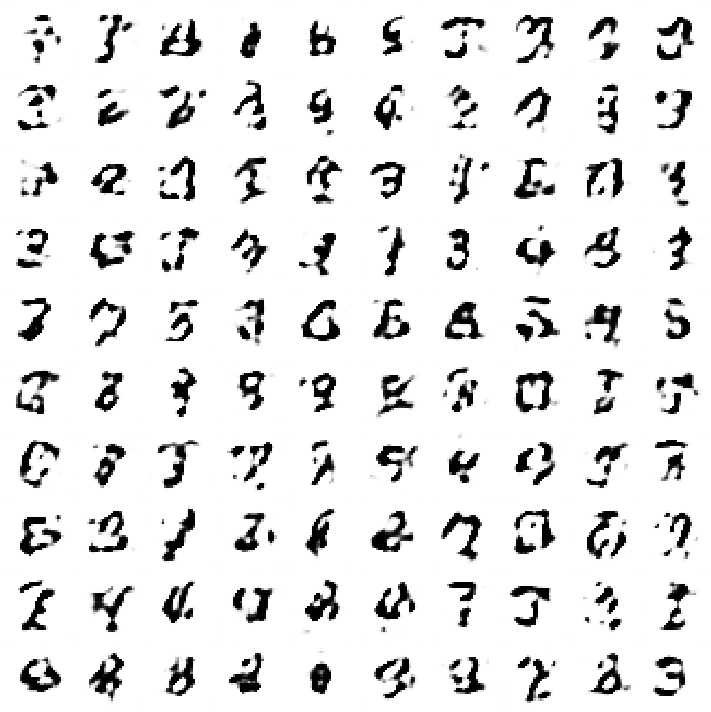

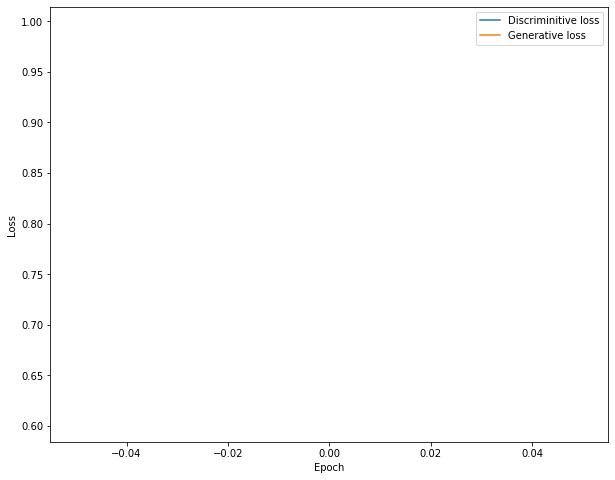

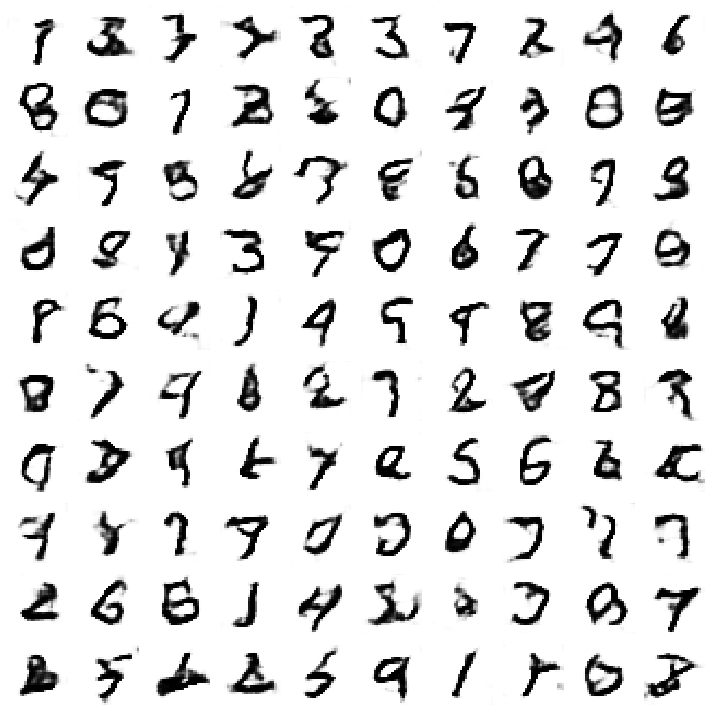

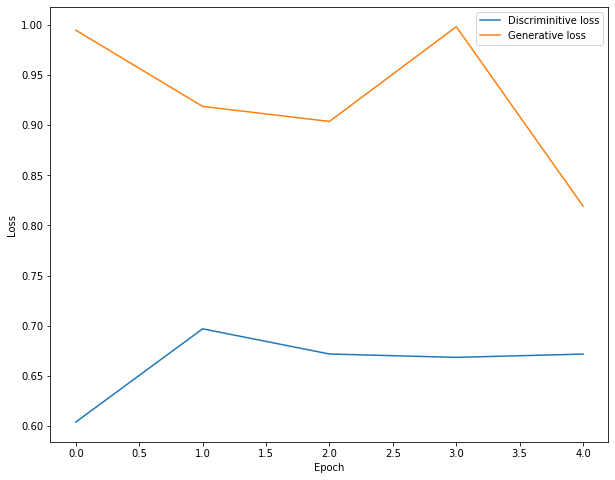

In [4]:
epochs = 5
batchSize = 128
batchCount = X_train.shape[0] / batchSize

print('Epochs:', epochs)
print('Batch size:', batchSize)
print('Batches per epoch:', batchCount)

for e in range(1, epochs+1):
    print('-'*15, 'Epoch %d' % e, '-'*15)
    for i in tqdm(range(int(batchCount))):
        noise = np.random.normal(0, 1, size=[batchSize, latent_dim])
        imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

        generatedImages = generator.predict(noise)
        X = np.concatenate([imageBatch, generatedImages])

        yDis = np.zeros(2*batchSize)
        yDis[:batchSize] = 0.9

        discriminator.trainable = True
        dloss = discriminator.train_on_batch(X, yDis)

        noise = np.random.normal(0, 1, size=[batchSize, latent_dim])
        yGen = np.ones(batchSize)
        discriminator.trainable = False
        gloss = gan.train_on_batch(noise, yGen)

    dLosses.append(dloss)
    gLosses.append(gloss)

    if e == 1 or e % 5 == 0:
        plotGeneratedImages(e)
        
        plotLoss(e)

